In [0]:
# cd '/content/drive/My Drive/Colab Notebooks/Amazon/Data'

In [0]:
!curl -L https://www.dropbox.com/s/qsdq7sx946t39pa/amazon.tar?dl=1 -o amazon.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  637M  100  637M    0     0  50.8M      0  0:00:12  0:00:12 --:--:-- 58.0M


In [0]:
!tar xvf amazon.tar

Streaming output truncated to the last 5000 lines.
amazon/train-jpg/train_19718.jpg
amazon/train-jpg/train_38480.jpg
amazon/train-jpg/train_16787.jpg
amazon/train-jpg/train_621.jpg
amazon/train-jpg/train_28212.jpg
amazon/train-jpg/train_29928.jpg
amazon/train-jpg/train_30979.jpg
amazon/train-jpg/train_12790.jpg
amazon/train-jpg/train_37996.jpg
amazon/train-jpg/train_4564.jpg
amazon/train-jpg/train_423.jpg
amazon/train-jpg/train_15263.jpg
amazon/train-jpg/train_28557.jpg
amazon/train-jpg/train_17206.jpg
amazon/train-jpg/train_28792.jpg
amazon/train-jpg/train_12157.jpg
amazon/train-jpg/train_3899.jpg
amazon/train-jpg/train_34358.jpg
amazon/train-jpg/train_9458.jpg
amazon/train-jpg/train_15756.jpg
amazon/train-jpg/train_6353.jpg
amazon/train-jpg/train_2794.jpg
amazon/train-jpg/train_34451.jpg
amazon/train-jpg/train_11776.jpg
amazon/train-jpg/train_26449.jpg
amazon/train-jpg/train_15881.jpg
amazon/train-jpg/train_21669.jpg
amazon/train-jpg/train_31322.jpg
amazon/train-jpg/train_3449.jpg
am

In [0]:
import pandas as pd
import numpy as np
np.random.seed(0)

import cv2

from tqdm.notebook import tqdm
import os

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.applications import ResNet50, VGG16

from sklearn.metrics import fbeta_score
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

import gc

In [0]:
import tensorflow.keras.applications
dir(tensorflow.keras.applications)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'densenet',
 'imagenet_utils',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'nasnet',
 'resnet',
 'resnet50',
 'resnet_v2',
 'vgg16',
 'vgg19',
 'xception']

In [0]:
all_base_models = ['DenseNet121', 'DenseNet169', 'DenseNet201', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception']
for model in all_base_models:
  exec('from tensorflow.keras.applications import {}'.format(model))

base_model_names = ['Xception', 'InceptionV3', 'VGG16', 'ResNet50', 'MobileNet']

In [0]:
df_train = pd.read_csv('amazon/train_v2.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
def read_data(df_train, labels, resize=(32, 32)):
    X_train = []
    y_train = []

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}

    for f, tags in tqdm(df_train.values, miniters=1000):
        if False == os.path.exists('amazon/train-jpg/{}.jpg'.format(f)): continue

        img = cv2.imread('amazon/train-jpg/{}.jpg'.format(f))
        targets = np.zeros(len(label_map))
        for t in tags.split(' '):
            targets[label_map[t]] = 1 

        X_train.append(cv2.resize(img, resize))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    X_train = np.array(X_train, np.float16) / 255.
    
    # split = 5000#35000
    train_split = 5000
    test_split = 1000
    
    # X_train, X_test, y_train, y_test
    return X_train[:train_split], X_train[train_split:train_split+test_split], y_train[:train_split], y_train[train_split:train_split+test_split]

def score_model(model):
  y_pred = model.predict(X_test, batch_size=128)
  score = fbeta_score(y_test, np.array(y_pred) > 0.2, beta=2, average='samples')

  print("\nTest score (f1): ", score)
  print("Error: %.2f%%" % (100-score*100))
  print('\n\n')

def fbeta_score_K(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

    return result

In [0]:
all_labels = df_train['tags'].map(lambda x: x.split(' ')).values
labels = list(set([y for x in all_labels for y in x]))

print( len(labels), labels )

17 ['water', 'selective_logging', 'agriculture', 'habitation', 'conventional_mine', 'artisinal_mine', 'cultivation', 'blooming', 'blow_down', 'haze', 'road', 'bare_ground', 'clear', 'partly_cloudy', 'cloudy', 'slash_burn', 'primary']


## Custom CNN

In [0]:
X_train, X_test, y_train, y_test = read_data(df_train, labels, resize=(64, 64))

In [0]:
X_train.shape

(5000, 64, 64, 3)

In [0]:
model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Flatten(), 

        Dense(1024, activation='relu'),        
        Dense(512, activation='relu'),
        Dense(17, activation='sigmoid') 
        ])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 14, 14, 128)      

Epoch 1/30
40/40 [==============================] - 1s 33ms/step - loss: 0.3516 - accuracy: 0.0360 - val_loss: 0.2564 - val_accuracy: 0.0000e+00
Epoch 2/30
40/40 [==============================] - 1s 29ms/step - loss: 0.2517 - accuracy: 0.0000e+00 - val_loss: 0.2467 - val_accuracy: 0.0000e+00
Epoch 3/30
40/40 [==============================] - 1s 29ms/step - loss: 0.2449 - accuracy: 0.0000e+00 - val_loss: 0.2379 - val_accuracy: 0.0000e+00
Epoch 4/30
40/40 [==============================] - 1s 29ms/step - loss: 0.2335 - accuracy: 0.0012 - val_loss: 0.2411 - val_accuracy: 0.0000e+00
Epoch 5/30
40/40 [==============================] - 1s 30ms/step - loss: 0.2210 - accuracy: 0.0232 - val_loss: 0.2347 - val_accuracy: 0.0370
Epoch 6/30
40/40 [==============================] - 1s 29ms/step - loss: 0.2157 - accuracy: 0.0206 - val_loss: 0.2156 - val_accuracy: 0.0410
Epoch 7/30
40/40 [==============================] - 1s 29ms/step - loss: 0.2115 - accuracy: 0.0242 - val_loss: 0.2057 - val_accura

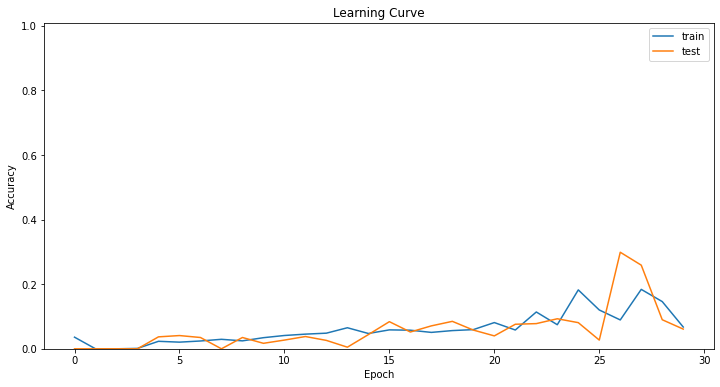

In [0]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=30,
          verbose=1,
          validation_data=(X_test, y_test))

print()
score_model(model)
draw_learning_curve(history)

##Transfer layrning (manual)

In [0]:
# del X_train, X_test, y_train, y_test
# gc.collect()

X_train, X_test, y_train, y_test = read_data(df_train, labels, resize=(48, 48))

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

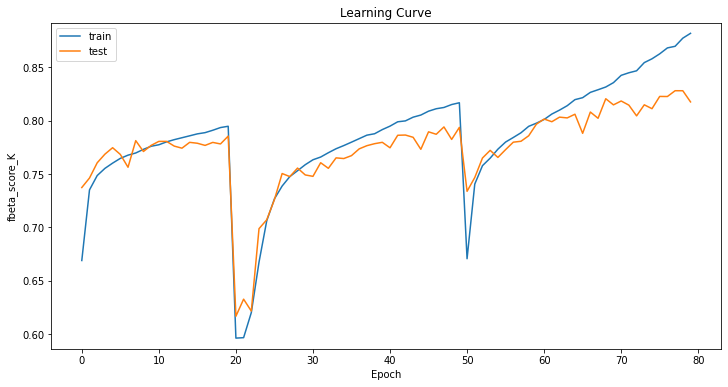

In [0]:
trainable_layers = [0, 4, 8]
epochs           = [20, 30, 30]
test_plan = zip(trainable_layers, epochs)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
test_base_model(base_model, test_plan)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

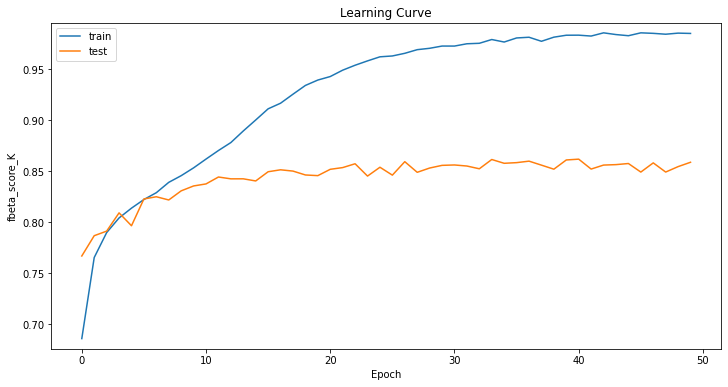

In [0]:
trainable_layers = [-1]
epochs           = [50]
test_plan = zip(trainable_layers, epochs)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
test_base_model(base_model, test_plan)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

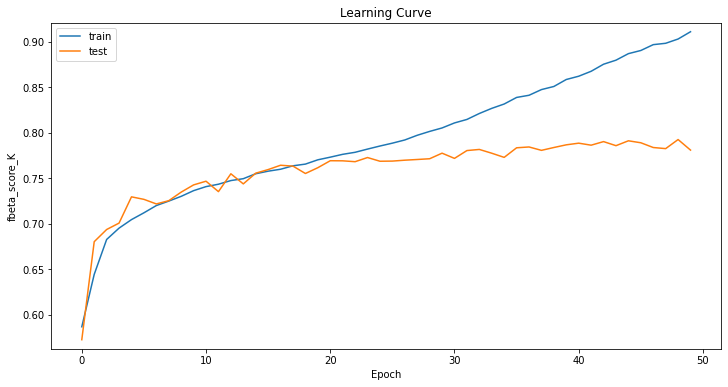

In [0]:
trainable_layers = [0, -1]
epochs           = [0, 50]
test_plan = zip(trainable_layers, epochs)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
test_base_model(base_model, test_plan)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

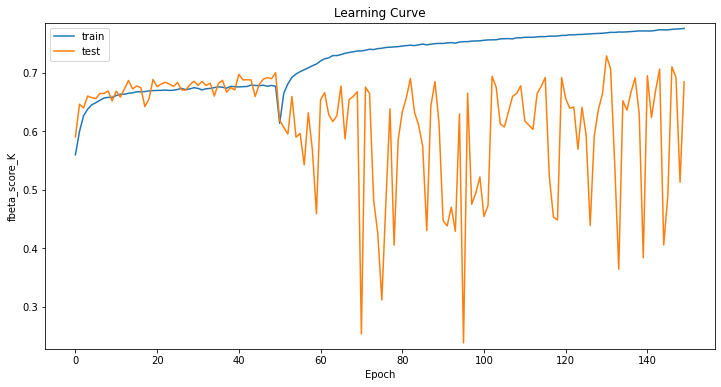

In [0]:
trainable_layers = [0, 20, 39]
epochs           = [50, 100, 0]
test_plan = zip(trainable_layers, epochs)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
test_base_model(base_model, test_plan)

##Using test loop

In [0]:
train_history = []
test_history = []


def test_base_model(base_model, test_plan, verbose=0):
  test_plan = list(test_plan)
  global train_history
  global test_history
  train_history = []
  test_history = []
  
  
  model = add_mlp_to_base_model(base_model)
  if verbose > 0:
    base_model.summary()
    model.summary()
  else:
    print('!! Now wroking witn base model: {}'.format(base_model.name))
  metrics = [fbeta_score_K]
  
  
  for test_stage, (trainable_layers, epochs) in enumerate(test_plan):
    if epochs == 0: continue
    if test_stage == 1:
      optimizer = Adam(0.003, decay=0.0005)
    else:
      optimizer = Adam(0.0003, decay=0.000005)
    
    set_trainable_layers(model, trainable_layers)
    print_trainable_count(model)
    training_cycle(model, optimizer, metrics, epochs, verbose)

  draw_learning_curve([train_history, test_history], metrics[0], test_plan)

def training_cycle(model, optimizer, metrics, epochs, verbose):
  global train_history
  global test_history

  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
  history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=epochs,
          verbose=verbose,
          validation_data=(X_test, y_test))
  
  train_history += history.history[metrics[0].__name__]
  test_history += history.history['val_' + metrics[0].__name__]
  # score_model(model)

def set_trainable_layers(model, trainable_layers):
  if trainable_layers < 0: trainable_layers = len(model.layers[0].layers)

  if trainable_layers >= 0:
    print('\n{} last cnn layers of {} total are now trainable'.format(trainable_layers, len(model.layers[0].layers)))
  else:
    print('\n all layers are trainable\n')

  for layer in model.layers[0].layers:
    layer.trainable = False

  if trainable_layers == 0: return 

  for layer in model.layers[0].layers[-trainable_layers:]:
    layer.trainable = True



def print_trainable_count(model):
  trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
  non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
  
  print('\nTotal params: {:,}'.format(trainable_count + non_trainable_count))
  print('Trainable params: {:,}'.format(trainable_count))
  print('Non-trainable params: {:,}\n'.format(non_trainable_count))

def add_mlp_to_base_model(base_model):
  for layer in base_model.layers:
    layer.trainable = False
    
  model = Sequential([
      base_model,
      
      Flatten(), 
          
      Dense(512, activation='relu'),
      Dropout(0.2),
      Dense(17, activation='sigmoid')
      
  ])

  return model

def draw_learning_curve(history, key='accuracy', test_plan=None):
  plt.figure(figsize=(12,6))

  if type(history) == tensorflow.python.keras.callbacks.History:
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    ylim = (0, 1.01)
    plt.ylabel(key.title())
  else:
    history = list(history)
    train_history = history[0]
    test_history = history[1]

    y_min = min(train_history + test_history) - 0.01
    y_max = max(train_history + test_history) + 0.01
    ylim = (y_min, y_max)
    plt.plot(train_history)
    plt.plot(test_history)

    end_of_test_step = 0
    for test_step in test_plan:
      end_of_test_step += test_step[1]
      plt.plot([end_of_test_step, end_of_test_step], [y_max, y_min])
    plt.ylabel(key.__name__)


  plt.title('Learning Curve')
  plt.xlabel('Epoch')
  plt.ylim(ylim)
  plt.legend(['train', 'test'], loc='best')
  plt.show()

In [0]:
# del X_train, X_test, y_train, y_test
# gc.collect()

X_train, X_test, y_train, y_test = read_data(df_train, labels, resize=(75, 75))

In [0]:
base_model = None
def get_models_info(base_models_names):
  for base_model_name in base_models_names:
    exec('base_model = {}(weights=\'imagenet\', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))'.format(base_model_name), globals())
    param_num = np.sum([K.count_params(w) for w in base_model.trainable_weights])
    layers = len(base_model.layers)
    print('model {0: <11} has {1: <4} layers and {2: ,d} total parameters'.format(base_model_name, layers, param_num))

In [0]:
base_model_names = ['Xception', 'InceptionV3', 'VGG16', 'ResNet50', 'MobileNet']
get_models_info(base_model_names)

model Xception    has 132  layers and  20,806,952 total parameters
model InceptionV3 has 311  layers and  21,768,352 total parameters
model VGG16       has 19   layers and  14,714,688 total parameters
model ResNet50    has 175  layers and  23,534,592 total parameters
model MobileNet   has 87   layers and  3,206,976 total parameters


83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 37, 37, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 37, 37, 32)   0           block1_conv1_bn[0][0]            
__________________________

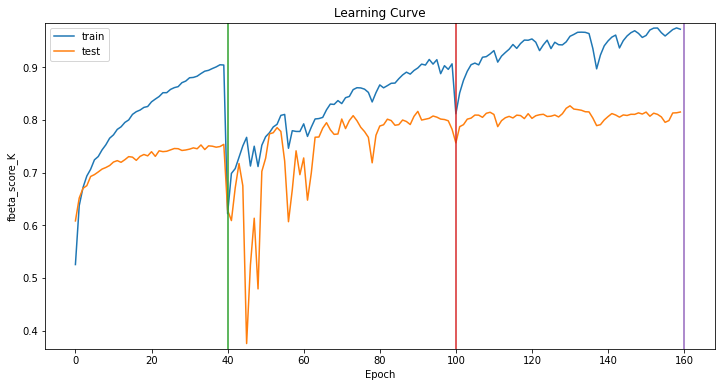

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 37, 37, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 37, 37, 32)   96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization_4[0][0]      
______________________

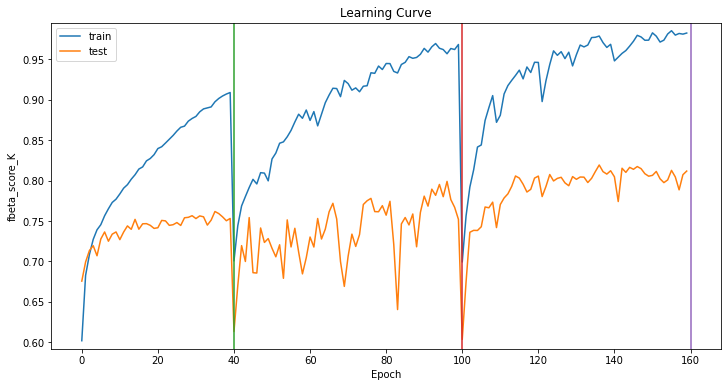

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
______________________________________________________________

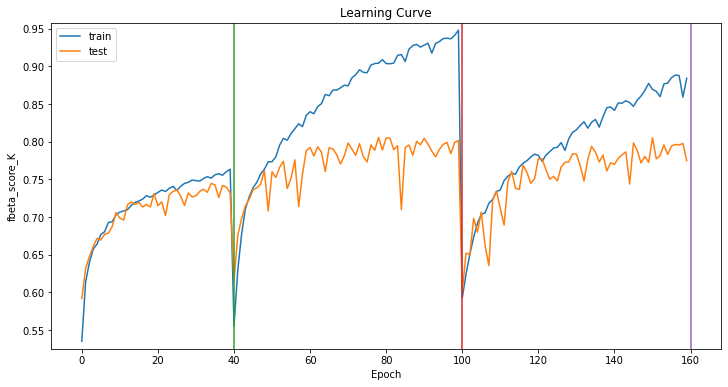

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 81, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 38, 38, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 38, 38, 64)   256         conv1_conv[0][0]                 
__________________________

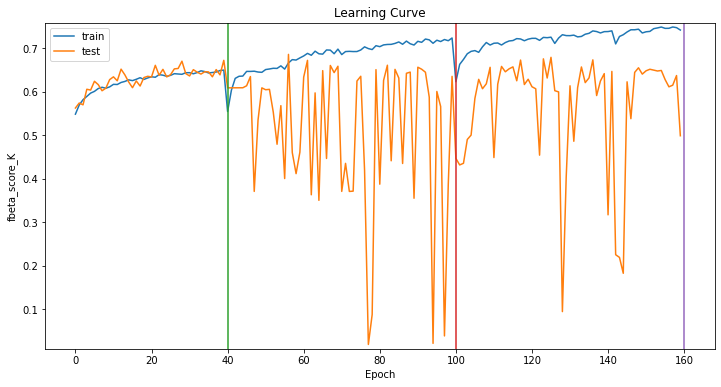

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 76, 76, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 37, 37, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 37, 37, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 37, 37, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 37, 37, 32)        288       
_________________________________________________

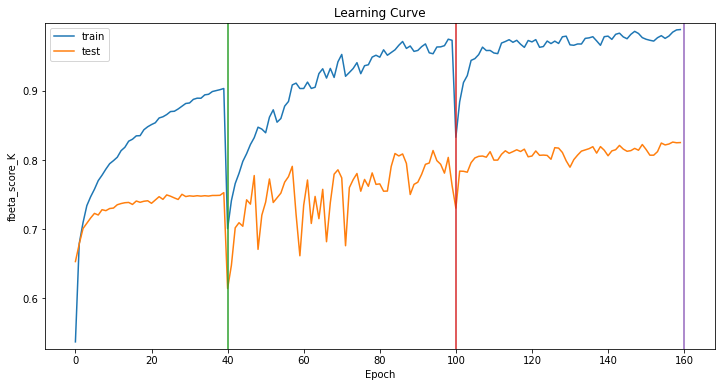

In [0]:
for base_model_names in base_models:

  exec('base_model = {}(weights=\'imagenet\', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))'.format(base_model))
  layers = len(base_model.layers)

  trainable_layers = [0, layers//4, layers//2]
  epochs           = [40, 60, 60]
  test_plan = zip(trainable_layers, epochs)

  test_base_model(base_model, test_plan, verbose=1)

!! Now wroking witn base model: xception

0 last cnn layers of 132 total are now trainable

Total params: 30,307,897
Trainable params: 9,446,417
Non-trainable params: 20,861,480


33 last cnn layers of 132 total are now trainable

Total params: 30,307,897
Trainable params: 18,924,761
Non-trainable params: 11,383,136


66 last cnn layers of 132 total are now trainable

Total params: 30,307,897
Trainable params: 24,304,681
Non-trainable params: 6,003,216



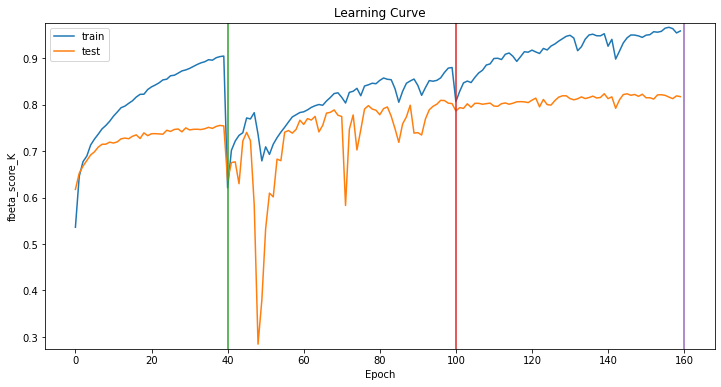

!! Now wroking witn base model: inception_v3

0 last cnn layers of 311 total are now trainable

Total params: 22,860,593
Trainable params: 1,057,809
Non-trainable params: 21,802,784


77 last cnn layers of 311 total are now trainable

Total params: 22,860,593
Trainable params: 13,463,825
Non-trainable params: 9,396,768


155 last cnn layers of 311 total are now trainable

Total params: 22,860,593
Trainable params: 17,699,793
Non-trainable params: 5,160,800



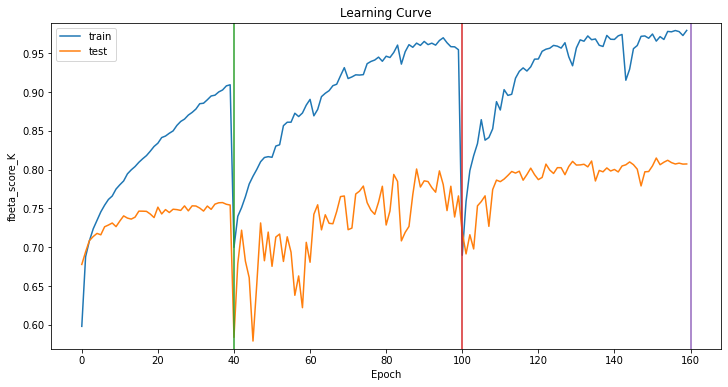

!! Now wroking witn base model: vgg16

0 last cnn layers of 19 total are now trainable

Total params: 15,772,497
Trainable params: 1,057,809
Non-trainable params: 14,714,688


4 last cnn layers of 19 total are now trainable

Total params: 15,772,497
Trainable params: 8,137,233
Non-trainable params: 7,635,264


9 last cnn layers of 19 total are now trainable

Total params: 15,772,497
Trainable params: 14,037,009
Non-trainable params: 1,735,488



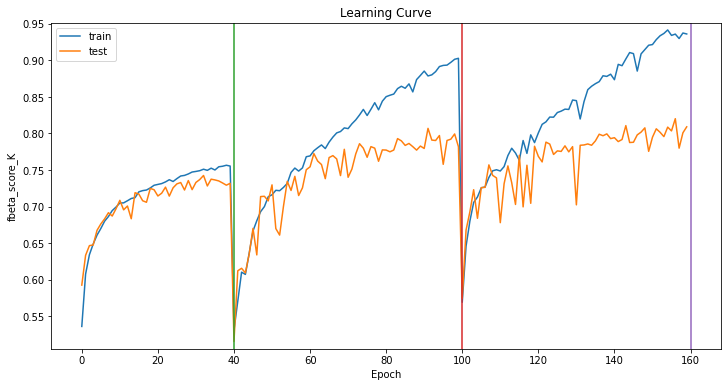

!! Now wroking witn base model: resnet50

0 last cnn layers of 175 total are now trainable

Total params: 33,034,129
Trainable params: 9,446,417
Non-trainable params: 23,587,712


43 last cnn layers of 175 total are now trainable

Total params: 33,034,129
Trainable params: 25,541,137
Non-trainable params: 7,492,992


87 last cnn layers of 175 total are now trainable

Total params: 33,034,129
Trainable params: 30,283,281
Non-trainable params: 2,750,848



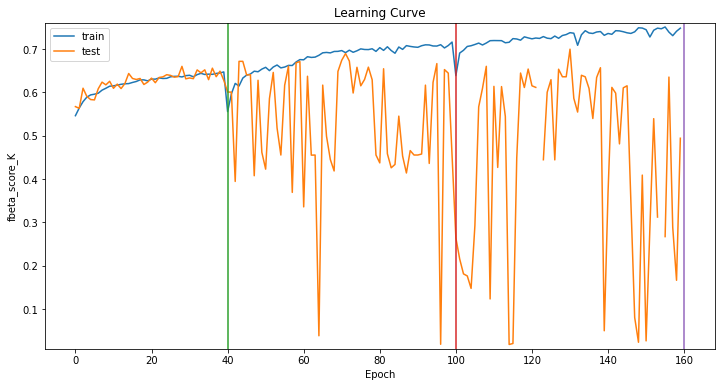

!! Now wroking witn base model: mobilenet_1.00_224

0 last cnn layers of 87 total are now trainable

Total params: 5,335,249
Trainable params: 2,106,385
Non-trainable params: 3,228,864


21 last cnn layers of 87 total are now trainable

Total params: 5,335,249
Trainable params: 3,970,065
Non-trainable params: 1,365,184


43 last cnn layers of 87 total are now trainable

Total params: 5,335,249
Trainable params: 5,044,241
Non-trainable params: 291,008



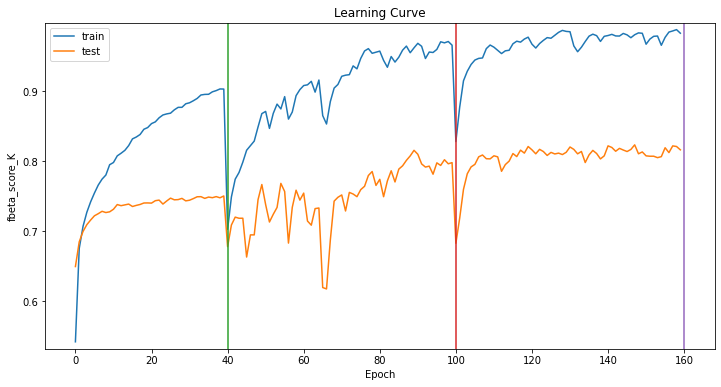

In [0]:
for base_model in base_model_names:

  exec('base_model = {}(weights=\'imagenet\', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))'.format(base_model))
  layers = len(base_model.layers)

  trainable_layers = [0, layers//4, layers//2]
  epochs           = [40, 60, 60]
  test_plan = zip(trainable_layers, epochs)

  test_base_model(base_model, test_plan, verbose=0)

!! Now wroking witn base model: xception

132 last cnn layers of 132 total are now trainable

Total params: 30,307,897
Trainable params: 30,253,369
Non-trainable params: 54,528



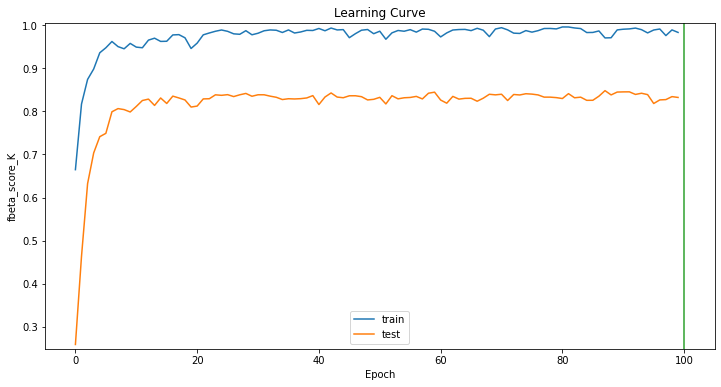

!! Now wroking witn base model: inception_v3

311 last cnn layers of 311 total are now trainable

Total params: 22,860,593
Trainable params: 22,826,161
Non-trainable params: 34,432



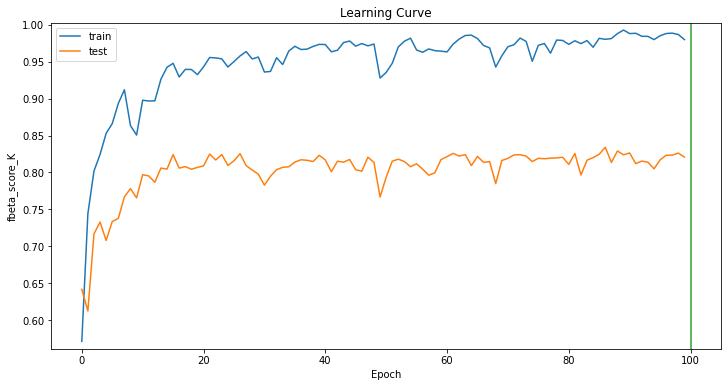

!! Now wroking witn base model: vgg16

19 last cnn layers of 19 total are now trainable

Total params: 15,772,497.0
Trainable params: 15,772,497
Non-trainable params: 0.0



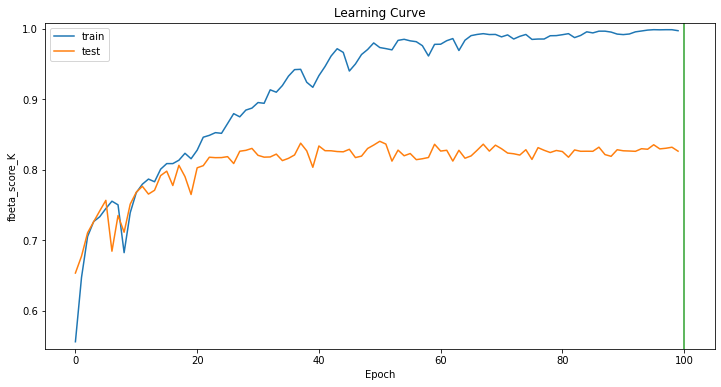

!! Now wroking witn base model: resnet50

175 last cnn layers of 175 total are now trainable

Total params: 33,034,129
Trainable params: 32,981,009
Non-trainable params: 53,120



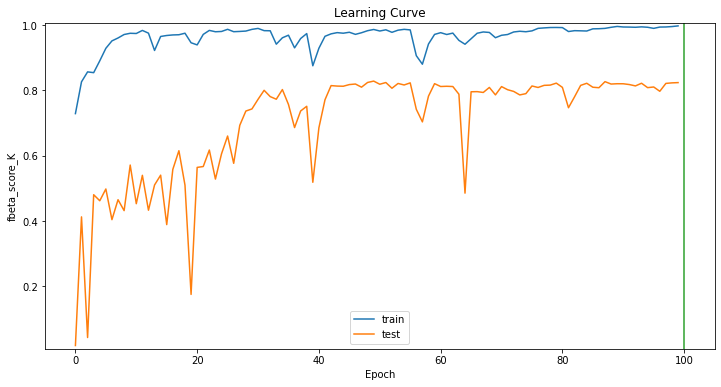

!! Now wroking witn base model: mobilenet_1.00_224

87 last cnn layers of 87 total are now trainable

Total params: 5,335,249
Trainable params: 5,313,361
Non-trainable params: 21,888



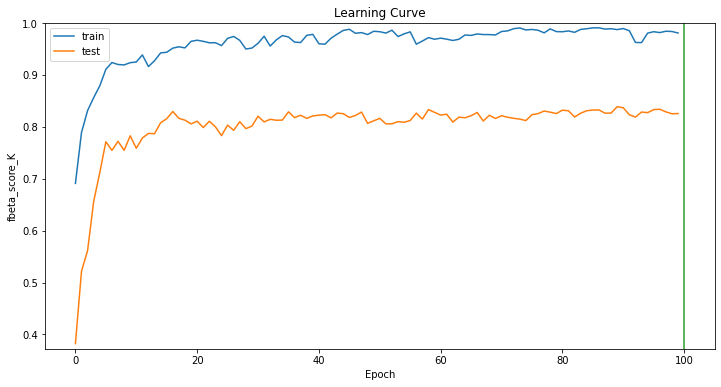

In [0]:
for base_model in base_model_names:

  exec('base_model = {}(weights=\'imagenet\', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))'.format(base_model))
  layers = len(base_model.layers)


  trainable_layers = [-1]
  epochs           = [100]
  test_plan = zip(trainable_layers, epochs)

  test_base_model(base_model, test_plan, verbose=0)

!! Now wroking witn base model: xception

132 last cnn layers of 132 total are now trainable

Total params: 30,307,897
Trainable params: 30,253,369
Non-trainable params: 54,528



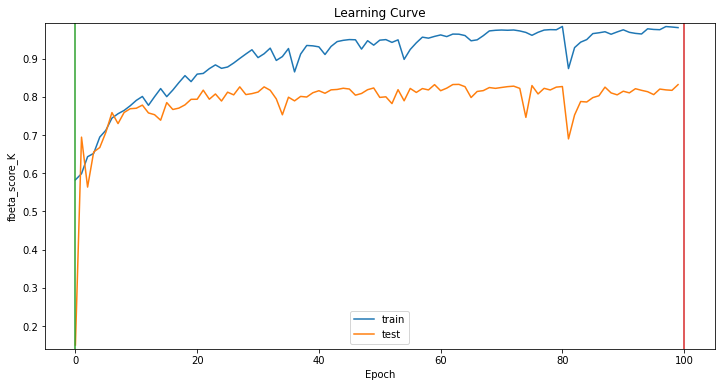

!! Now wroking witn base model: inception_v3

311 last cnn layers of 311 total are now trainable

Total params: 22,860,593
Trainable params: 22,826,161
Non-trainable params: 34,432



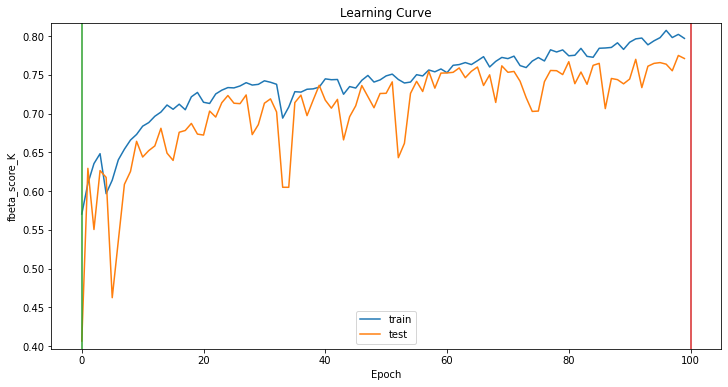

!! Now wroking witn base model: vgg16

19 last cnn layers of 19 total are now trainable

Total params: 15,772,497.0
Trainable params: 15,772,497
Non-trainable params: 0.0



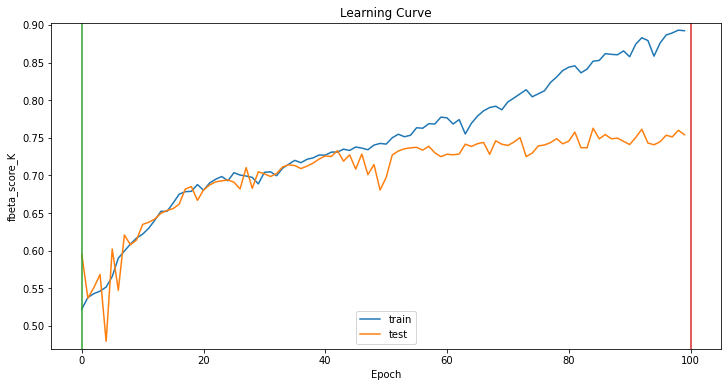

!! Now wroking witn base model: resnet50

175 last cnn layers of 175 total are now trainable

Total params: 33,034,129
Trainable params: 32,981,009
Non-trainable params: 53,120



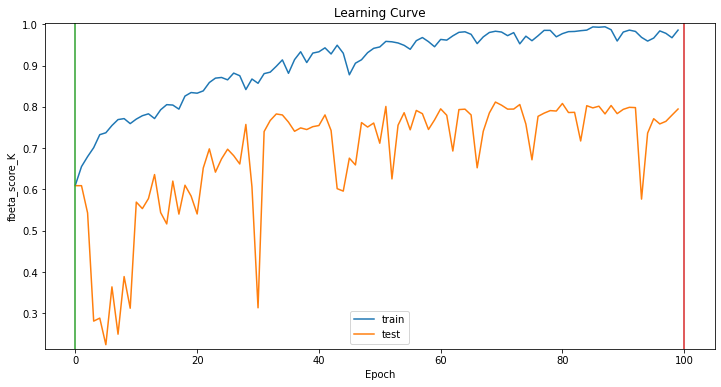

!! Now wroking witn base model: mobilenet_1.00_224

87 last cnn layers of 87 total are now trainable

Total params: 5,335,249
Trainable params: 5,313,361
Non-trainable params: 21,888



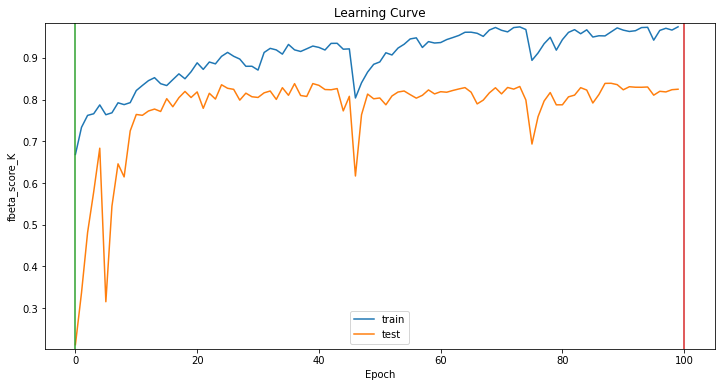

In [0]:
for base_model in base_model_names:

  exec('base_model = {}(weights=\'imagenet\', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))'.format(base_model))
  layers = len(base_model.layers)


  trainable_layers = [0, -1]
  epochs           = [0, 100]
  test_plan = zip(trainable_layers, epochs)

  test_base_model(base_model, test_plan, verbose=0)